In [1]:
# GTSRB (German Traffic Sign Recognition Benchmark) - 표지판(Traffic sign) 이미지 분류

# GTSRB (German Traffic Sign Recognition Benchmark) 데이터는 표지판(Traffic sign)을 예측하기 위해서 만든 데이터이며,
# 평균적으로 32x32 크기를 가지는 color 이미지로, 43개 교통 표지판과 관련된 약 4만 개의 이미지를 포함

# Conv Layer -> Conv Layer -> MaxPooling Layer -> Flatten Layer -> Linear -> Linear
# 데이터 다운로드 및 로드 -> 데이터 전처리 -> 모델 아키텍처 구성 -> 모델 학습 및 평가

In [2]:
# 라이브러리
import os
import shutil
import glob
import cv2
import zipfile
import random
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split

# GPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [4]:
# ===============================
# 데이터 경로 설정
# ===============================
ROOT_DIR = '.\\data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'GTSRB\\Final_Training\\Images')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')
# os.mkdir(os.path.join(DATA_ROOT_DIR, 'Training'))
# os.mkdir(os.path.join(DATA_ROOT_DIR, 'Testing'))

In [5]:
# 데이터 폴더 존재시 삭제
if os.path.exists('.\\data\\GTSRB'):
    shutil.rmtree('.\\data\\GTSRB')
    print('.\\data\\GTSRB is removed')

.\data\GTSRB is removed


In [7]:
# 압축 해제
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'GTSRB_Final_Training_Images.zip'), 'r') as target_file:
    target_file.extractall(ROOT_DIR)

In [36]:
# 데이터 재구축 - Testing 데이터 -> Training 데이터
# - Testing 데이터와 Training 데이터가 이질적이기 때문에 학습 정확도와 테스트 정확도의 편차를 줄여서 모델의 신뢰성을 높이기 위함
# 1) 학습 전에 Testing 데이터와 Training 데이터를 혼합하고
# 2) Training : Testing = 8 : 2 비율로 데이터를 재구축

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list: # Testing 디렉토리 각각의 label(정답)
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    # print(test_path)
    test_file_list = os.listdir(test_path) # label 디렉토리에 있는 이미지 파일 목록을 뽑아냄
    # print(test_file_list)
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    # print(train_path)
    moved_num = 0

    for test_image_file in test_file_list: # 모든 이미지 파일
        # Testing 디렉토리 이미지 파일을 동일한 label의 Training 디렉토리로 이동
        shutil.move(os.path.join(test_path, test_image_file),
                    os.path.join(train_path, test_image_file))
        
        moved_num = moved_num + 1
    
    print(str(moved_num) + ' is moved into ' + label_name + ' (Testing => Training)')

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']
211 is moved into 00000 (Testing => Training)
2221 is moved into 00001 (Testing => Training)
2251 is moved into 00002 (Testing => Training)
1411 is moved into 00003 (Testing => Training)
1981 is moved into 00004 (Testing => Training)
1861 is moved into 00005 (Testing => Training)
421 is moved into 00006 (Testing => Training)
1441 is moved into 00007 (Testing => Training)
1411 is moved into 00008 (Testing => Training)
1471 is moved into 00009 (Testing => Training)
2011 is moved into 00010 (Testing => Training)
1321 is moved into 00011 (Testing => Training)
2101 is moved into 00012 (Testing => Training)
216

In [38]:
# 데이터 재구축 - Training 데이터 -> Testing 데이터

MOVE_RATIO = 0.2 # train : test = 80 : 20, 즉 train 데이터 20% 데이터를 test 데이터로 사용

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(label_name_list)

for label_name in label_name_list: # Training 디렉토리 각각의 label(정답)
    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src_dir_path) # label 디렉토리에 있는 이미지 파일 목록을 뽑아냄
    random.shuffle(train_data_file_list)
    # print(train_data_file_list)

    # 데이터 다양성을 위해 train data를 random하게 shuffle 한 후에, test data list 생성
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num]

    # shutil.move 이용해서 Training 디렉토리에서 20% 비율로 test data를 생성해서 Testing 디렉토리로 이동
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [5]:
# ===============================
# Dataset 준비
# ===============================
IMG_WIDTH, IMG_HEIGHT = 32, 32
BATCH_SIZE = 32

# transforms 설정
train_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 기준 정규화
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# datasets.ImageFolder
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DATA_ROOT_DIR, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 정답 label
class_names = train_dataset.classes
print('클래스 : ', class_names)

클래스 :  ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..0.11276696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8256302..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.57068247..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.57068247..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..0.8447932].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.64].
Clipping 

torch.Size([32, 3, 32, 32]) torch.Size([32])
{0: '00000', 1: '00001', 2: '00002', 3: '00003', 4: '00004', 5: '00005', 6: '00006', 7: '00007', 8: '00008', 9: '00009', 10: '00010', 11: '00011', 12: '00012', 13: '00013', 14: '00014', 15: '00015', 16: '00016', 17: '00017', 18: '00018', 19: '00019', 20: '00020', 21: '00021', 22: '00022', 23: '00023', 24: '00024', 25: '00025', 26: '00026', 27: '00027', 28: '00028', 29: '00029', 30: '00030', 31: '00031', 32: '00032', 33: '00033', 34: '00034', 35: '00035', 36: '00036', 37: '00037', 38: '00038', 39: '00039', 40: '00040', 41: '00041', 42: '00042'}


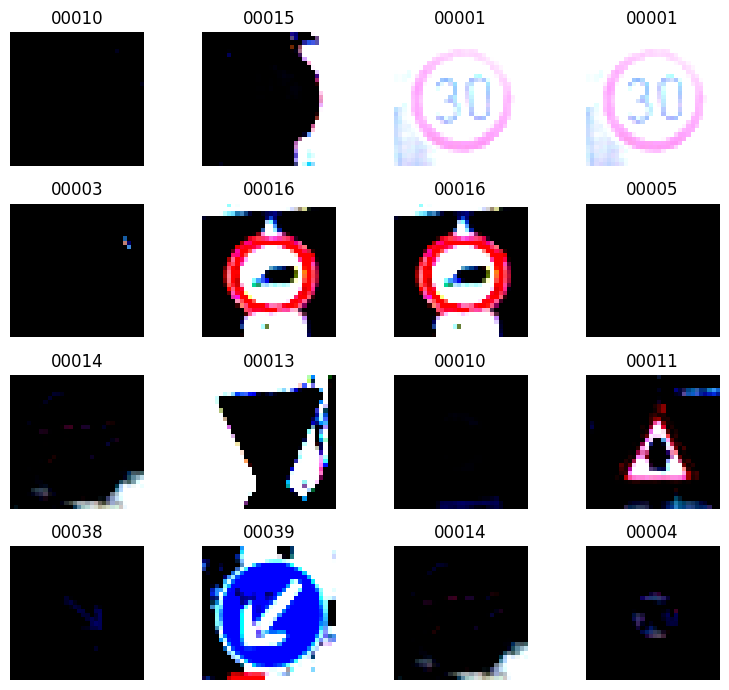

In [6]:
# 1개 배치 추출
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# labels map 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1, )).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# ======================
# CNN 모델 정의
# ======================
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 256),  # 32x32 → conv(3x3)x2 → 28x28 → pool(2x2) → 14x14
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
# ======================
# 모델객체 & 손실함수 & 옵티마이저
# ======================
n_classes = len(class_names)
model = CNNModel(n_classes).to(DEVICE)
print(model)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=43, bias=True)
  )
)


In [13]:
# ===============================
# 학습 함수
# ===============================
def train_model(model, loss_function, optimizer, train_loader, val_loader, num_epochs=50, patience=5):
    best_loss = np.inf
    counter = 0
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for epoch in range(num_epochs):
        # --- Train ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # 미분 초기화
            outputs = model(inputs) # 모델 예측
            loss = loss_function(outputs, labels) # 손실함수 계산

            _, preds = torch.max(outputs, 1) # 예측값 분리
            loss.backward() # 미분 연산
            optimizer.step() # 미분 연산 후 파라미터(가중치, 바이어스) 업데이트

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset) # 평균 손실함수값
        epoch_acc = running_corrects.double() / len(train_loader.dataset) # 평균 정확도값
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad(): # 오차역전파 사용 안함, 미분 연산 하지 않음
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # 모델 예측
                loss = loss_function(outputs, labels) # 손실함수값 계산

                _, preds = torch.max(outputs, 1) # 예측값 분리
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset) # validation 평균 손실함수값
        val_acc = val_running_corrects.double() / len(val_loader.dataset) # validation 평균 정확도값
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                model.load_state_dict(best_model_wts)
                break

    return model, (train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)

In [14]:
# ===============================
# 학습 실행
# ===============================
model, history = train_model(model, loss_function, optimizer, train_loader, test_loader, num_epochs=30)

Epoch 1/30 - Train loss: 0.8073, acc: 0.7721 Val loss: 0.1034, acc: 0.9756
Epoch 2/30 - Train loss: 0.1881, acc: 0.9443 Val loss: 0.0547, acc: 0.9879
Epoch 3/30 - Train loss: 0.1218, acc: 0.9626 Val loss: 0.0462, acc: 0.9897
Epoch 4/30 - Train loss: 0.0873, acc: 0.9742 Val loss: 0.0331, acc: 0.9909
Epoch 5/30 - Train loss: 0.0766, acc: 0.9776 Val loss: 0.0348, acc: 0.9909
Epoch 6/30 - Train loss: 0.0733, acc: 0.9777 Val loss: 0.0291, acc: 0.9925
Epoch 7/30 - Train loss: 0.0521, acc: 0.9835 Val loss: 0.0342, acc: 0.9921
Epoch 8/30 - Train loss: 0.0526, acc: 0.9839 Val loss: 0.0332, acc: 0.9943
Epoch 9/30 - Train loss: 0.0536, acc: 0.9851 Val loss: 0.0262, acc: 0.9946
Epoch 10/30 - Train loss: 0.0522, acc: 0.9856 Val loss: 0.0348, acc: 0.9941
Epoch 11/30 - Train loss: 0.0429, acc: 0.9871 Val loss: 0.0368, acc: 0.9917
Epoch 12/30 - Train loss: 0.0397, acc: 0.9881 Val loss: 0.0401, acc: 0.9914
Epoch 13/30 - Train loss: 0.0389, acc: 0.9882 Val loss: 0.0260, acc: 0.9949
Epoch 14/30 - Train l

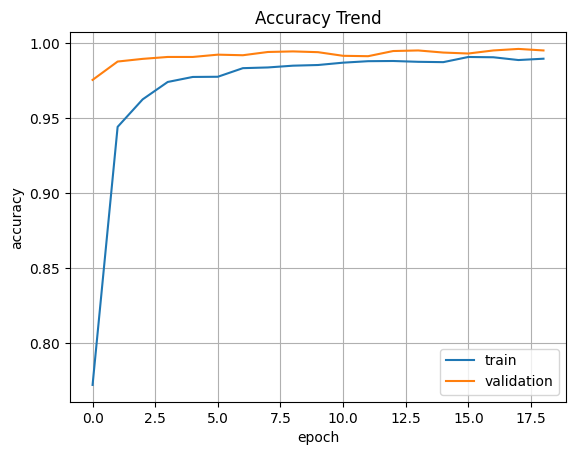

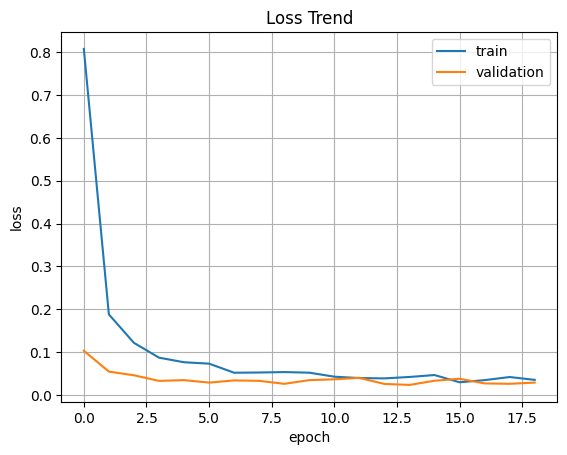

In [15]:
# ======================
# 정확도 및 손실 그래프
# ======================
# ===============================
# 성능 시각화
# ===============================
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = history

plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='validation')
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [16]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_cnn_gtsrb_traffic.ckpt')

In [17]:
# ===============================
# 테스트 성능 평가
# ===============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.53%
